# Data exploration

In [1]:
import sys
import numpy as np
import pandas as pd
if '../' not in sys.path: sys.path.insert(1, '../')
import src.data.load_data as data

## General stuff

Let's first load the raw dataset and take a look:

In [2]:
df = data.load_data('../data/raw/filtered.tsv', drop_columns=False, sort_toxicity=False, flatten=False)
df

It is unclear how can the columns `similarity` and `length_diff` be used in order to train the model for text detoxification, therefore we can drop these right away:

In [4]:
data.drop_extra_columns_inplace(df)
df

,reference,translation,ref_tox,trn_tox
0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.014195,0.981983
1,Now you're getting nasty.,you're becoming disgusting.,0.065473,0.999039
2,"Well, we could spare your life, for one.","well, we can spare your life.",0.213313,0.985068
3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.053362,0.994215
4,I've got orders to put her down.,I have orders to kill her.,0.009402,0.999348
...,...,...,...,...
577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.000121,0.949143
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.991945,0.000124


After closer look it is also apparent that the toxicity score of reference is not always higher than that of the translation. Since we want to perform a seq2seq training, it would be beneficial to have one column strictly more toxic than the other one:

In [5]:
data.sort_by_toxicity_inplace(df)
df

,reference,translation,ref_tox,trn_tox
0,"if Alkar floods her with her mental waste, it ...","If Alkar is flooding her with psychic waste, t...",0.981983,0.014195
1,you're becoming disgusting.,Now you're getting nasty.,0.999039,0.065473
2,"well, we can spare your life.","Well, we could spare your life, for one.",0.985068,0.213313
3,"monkey, you have to wake up.","Ah! Monkey, you've got to snap out of it.",0.994215,0.053362
4,I have orders to kill her.,I've got orders to put her down.,0.999348,0.009402
...,...,...,...,...
577772,you didn't know that Estelle stole your fish f...,You didn't know that Estelle had stolen some f...,0.949143,0.000121
577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.996124,0.215794
577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.984538,0.000049
577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.991945,0.000124


Now the reference column contains toxic text, whereas translation column contains a less toxic version of the text.

## Toxicity of columns

Now I want to see statistics on toxicity score for both of the columns:

In [8]:
print(df['ref_tox'].describe(), end='\n\n')
print(df['trn_tox'].describe())

count    577777.000000
mean          0.940260
std           0.100831
min           0.500139
25%           0.940145
50%           0.983842
75%           0.997519
max           0.999730
Name: ref_tox, dtype: float64

count    577777.000000
mean          0.035601
std           0.079399
min           0.000033
25%           0.000164
50%           0.003456
75%           0.027242
max           0.499494
Name: trn_tox, dtype: float64


Now that tells us a couple of things: first, the reference column is mostly toxic, and translation column is mostly neutral (which can be seen by `mean` value). This is exactly what we need to train a model to detoxify text. The second thing is, we can conviniently select a threshold of $0.5$, since all `reference` toxicity scores are above that ($\text{min} = 0.50139$), and all `translation` toxicity scores are below that ($\text{max} = 0.499494$)

We can take a look at the most "toxic" examples from translations:

In [10]:
pd.set_option('display.max_colwidth', 50)
toxic_translations = df[:][df['trn_tox'] > 0.49]
toxic_translations.head(10)

,reference,translation,ref_tox,trn_tox
2813,this is no more stupid competition.,This ain't a bloody competition anymore.,0.999649,0.499419
4556,stop treating me like a fool!,Stop this nonsense!,0.997514,0.497011
6366,"That's nice. You gay, her father. It's nice.","that's nice, gay and his daughter.",0.999041,0.492353
6700,the guy treats you like shit 'cause he's a doc...,This guy treats you like dirt... ...because he...,0.999032,0.497258
6858,Another letter from that school goes to that k...,you get one letter to the guy...... and you'll...,0.998927,0.493065


As we can see these are mostly acceptable as neutral translations, which means our data is fine

## Several sentences?

In [8]:
flat_data = flatten_data(df)
all_sentences = flat_data['text']

In [9]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
mask = all_sentences.str.contains('.*[.;!?].*[.;!?].*')
all_sentences[:][mask]  

3                                                                                                  Ah! Monkey, you've got to snap out of it.
5                                                I'm not gonna have a child... ...with the same genetic disorder as me who's gonna die. L...
15                                             I swore when I went out with Xander Harris... ...I'd rather die than datea fixer-upper again.
17                                            To quote Jake Oppenheimer: I, who am about to die, must seem to them something "God-awful."...
18                                                                                     “Could you please be quiet, Miss Lavish?” said Moist.
                                                                         ...                                                                
1155473                                                                      Mr. Palmer, if you're done with your interstitial ineptitude...
1155474    I 

## Max token count?

In [10]:
tokens = all_sentences.str.split()
lengths = tokens.apply(len)

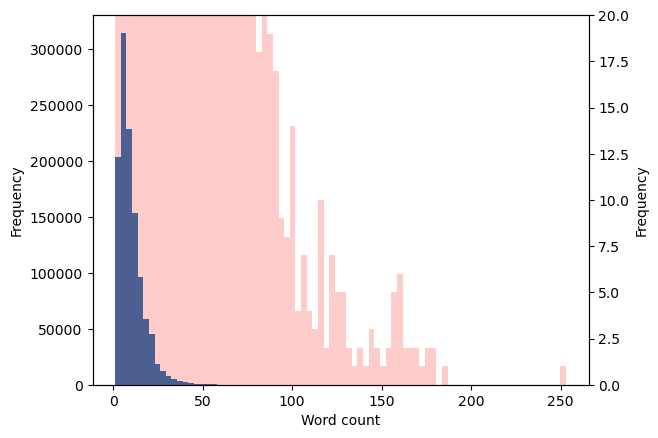

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Choose the column for the histogram
ax1 = lengths.plot(kind='hist', bins=80)
plt.xlabel('Word count')

ax2 = ax1.twinx()
lengths.plot(kind='hist', bins=80, ax=ax2, alpha=0.2, color='red')  # Adjust alpha for transparency if needed

ax2.set_ylim(0, 20)

# Display the histogram
plt.show()

In [34]:
1 - np.sum(lengths > 64) / len(lengths)

0.9995171147345775

In [48]:
lengths.sort_values(inplace=True)
np.sum(lengths > 64)

558